In [69]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('dataset music/data_playcount.csv')

users = df['id_user'].values
tracks = df['id_track'].values
initial_playcounts = df['count'].values
playcounts = 1 + (initial_playcounts - 1) * (5 - 1) / (50 - 1)
print(playcounts)


uniques = [np.unique(users).shape[0], np.unique(tracks).shape[0]]

print('number of unique users:', uniques[0])
print('number of unique tracks:', uniques[1])
print('number of playcounts:', users.shape[0])
print('total number of cells:', uniques[0] * uniques[1])
print('Ratio of entries filled:', users.shape[0]/(uniques[0] * uniques[1]))


[5.         5.         4.10204082 ... 1.         1.         1.        ]
number of unique users: 11
number of unique tracks: 67241
number of playcounts: 125763
total number of cells: 739651
Ratio of entries filled: 0.17003018991389182


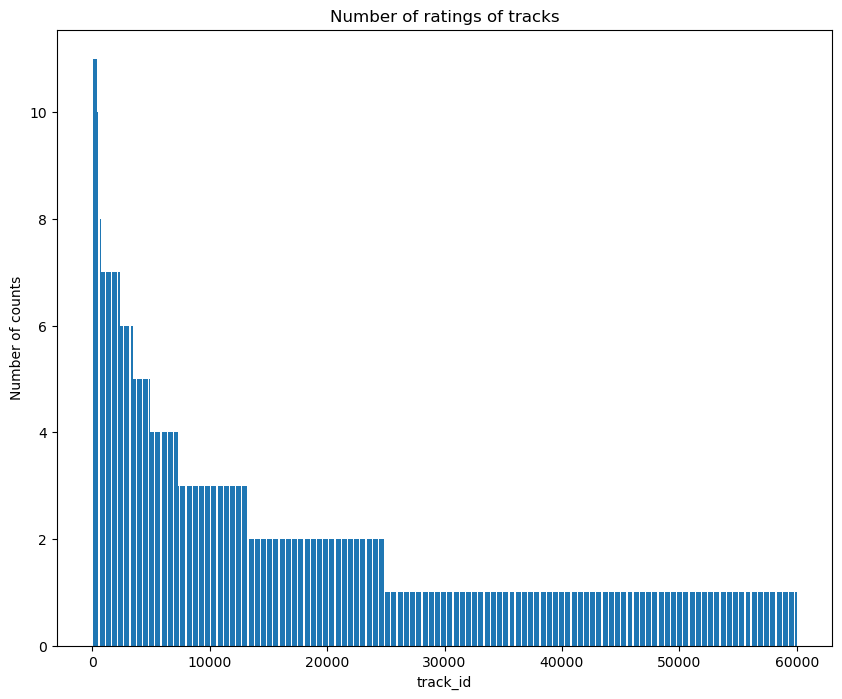

In [37]:
track_uniques = np.unique(tracks)

track_occurances = []
for track in track_uniques:
    occ = np.count_nonzero(tracks == track)
    track_occurances.append(occ)
track_occurances = np.array(track_occurances)

sort_indices = np.argsort(track_occurances) 

track_uniques_occ_sorted = track_uniques[sort_indices]
track_uniques_occ_sorted = track_uniques_occ_sorted[::-1]
track_uniques_occ_sorted = np.array(track_uniques_occ_sorted)

track_occurances_sorted = track_occurances[sort_indices]
track_occurances_sorted = track_occurances_sorted[::-1]

plt.figure(figsize=(10,8))
plt.bar(range(len(track_occurances_sorted[0:60000])), track_occurances_sorted[:60000])
plt.title('Number of ratings of tracks')
plt.xlabel('track_id')
plt.ylabel('Number of counts')
plt.show()

In [57]:
M = np.zeros((uniques[0], uniques[1]))
mask = np.zeros(M.shape)
for u, t, c in zip(users, tracks, playcounts):
    M[u, np.where(track_uniques_occ_sorted == t)[0][0]]= c
    mask[u, np.where(track_uniques_occ_sorted == t)[0][0]]= 1.
     
print(np.sum(mask))

125763.0


In [51]:
test_count = 60000
_is = np.random.randint(0, len(users), test_count)
 
test_mask = np.zeros(M.shape)
for i in _is:
    _user = users[i]
    _track = np.where(track_uniques_occ_sorted == tracks[i])[0][0]
    test_mask[_user, _track] = 1
     
print(np.sum(test_mask))

47829.0


In [63]:
cutoff = 30000
M = tf.constant(M[:,:cutoff], dtype = 'float32')
test_mask = tf.constant(test_mask[:,:cutoff], dtype = 'float32')
train_mask = tf.constant((mask[:,:cutoff] - test_mask[:,:cutoff]), dtype = 'float32')

print('Number of testing:', tf.reduce_sum(test_mask))
print('Number of training:', tf.reduce_sum(train_mask))


Number of testing: tf.Tensor(33626.0, shape=(), dtype=float32)
Number of training: tf.Tensor(54896.0, shape=(), dtype=float32)


In [91]:
def early_stopping(losses, patience = 5):
     
    if len(losses) <= patience + 1:
        return False
     
    avg_loss = np.mean(losses[-1 - patience:-1])
     
    if avg_loss - losses[-1] < 0.01*avg_loss:
        return True
     
    return False

In [115]:
latent_factors = [6, 7, 8, 9, 10]
train_losses_dict = {}
test_losses_dict = {}
for k in latent_factors:
    print(f"Training with {k} latent factors...")
    U_d = tf.Variable(tf.random.normal((11, 1)))
    V_d = tf.Variable(tf.random.normal((1, cutoff)))
    
    train_norm = tf.reduce_sum(train_mask)
    test_norm = tf.reduce_sum(test_mask)
    
    adam_opt = tf.keras.optimizers.Adam()
    from datetime import datetime
    lr = 0.001
    ep = 0
    start_time = datetime.now()
    train_losses = []
    test_losses = []
    
    while True:
        with tf.GradientTape() as tape:
            M_app = U_d @ V_d
            pred_errors_squared = tf.square(M - M_app)
            train_loss = tf.reduce_sum((train_mask * pred_errors_squared)/train_norm)
        test_loss = tf.reduce_sum((test_mask * pred_errors_squared) / test_norm)
    
        if ep%100 == 0:
            print(datetime.now() - start_time, train_loss, test_loss, ep)
            train_losses.append(train_loss.numpy())
            test_losses.append(test_loss.numpy())
        if early_stopping(train_losses):
            break
            
        grads = tape.gradient(train_loss, [U_d, V_d])
        adam_opt.apply_gradients(zip(grads, [U_d, V_d]))
    
        ep += 1
    train_losses_dict[k] = train_losses
    test_losses_dict[k] = test_losses
    


Training with 6 latent factors...
0:00:00.013355 tf.Tensor(4.2725186, shape=(), dtype=float32) tf.Tensor(4.737775, shape=(), dtype=float32) 0
0:00:01.896610 tf.Tensor(3.9656694, shape=(), dtype=float32) tf.Tensor(4.574821, shape=(), dtype=float32) 100
0:00:03.384373 tf.Tensor(3.7475216, shape=(), dtype=float32) tf.Tensor(4.4643807, shape=(), dtype=float32) 200
0:00:04.777583 tf.Tensor(3.585353, shape=(), dtype=float32) tf.Tensor(4.3881392, shape=(), dtype=float32) 300
0:00:06.148302 tf.Tensor(3.4571588, shape=(), dtype=float32) tf.Tensor(4.3353724, shape=(), dtype=float32) 400
0:00:07.585148 tf.Tensor(3.347753, shape=(), dtype=float32) tf.Tensor(4.2955365, shape=(), dtype=float32) 500
0:00:08.943715 tf.Tensor(3.2459307, shape=(), dtype=float32) tf.Tensor(4.259655, shape=(), dtype=float32) 600
0:00:10.362306 tf.Tensor(3.1434329, shape=(), dtype=float32) tf.Tensor(4.2206683, shape=(), dtype=float32) 700
0:00:11.750238 tf.Tensor(3.0347302, shape=(), dtype=float32) tf.Tensor(4.173931, shap

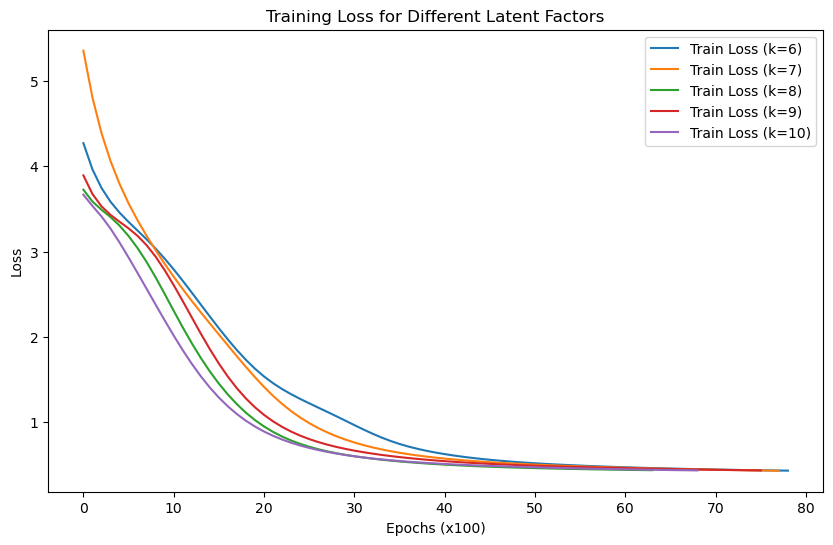

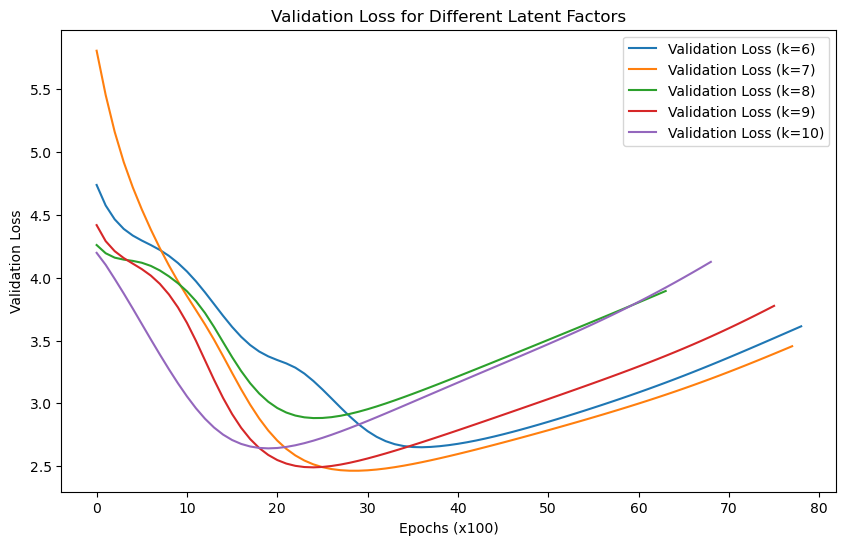

In [117]:
plt.figure(figsize=(10, 6))

for k in latent_factors:
    plt.plot(train_losses_dict[k], label=f'Train Loss (k={k})')

plt.xlabel('Epochs (x100)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss for Different Latent Factors')
plt.show()

plt.figure(figsize=(10, 6))
for k in latent_factors:
    plt.plot(test_losses_dict[k], label=f'Validation Loss (k={k})')

plt.xlabel('Epochs (x100)')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss for Different Latent Factors')
plt.show()